In [4]:
from collections import defaultdict
import traceback
import warnings
import os
import argparse

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from core import history as ch
from core.fine_model import FineModel

_depth_key = 'D{:02}'
_fold_key = 'D{:02}_L{:02}_F{:02}'
_epoch_key = 'D{:02}_L{:02}_F{:02}_E{:03}'

from params import *

FIGURE_DIR = 'figures'

metric_names = {
    'val_loss': 'Validation Loss',
    'loss': 'Training Loss',
    'val_acc': 'Validation Accuracy',
    'acc': 'Training Accuracy',
}

bounds_per_metric = {
    'val_loss': (0, 2),
    'loss': (0, 2),
    'val_acc': (0.3, 1),
    'acc': (0.3, 1)
}

In [5]:
METRICS = ['val_loss', 'val_acc', 'loss', 'acc']
DEPTH_INDEX = 0
FOLDS = 5

FOLD_KEY_FMT = 'D{:02}_L{:02}_F{:02}'
DEPTH_KEY_FMT = 'D{:02}'
EPOCH_KEY_FMT = 'D{:02}_L{:02}_F{:02}_E{:03}'

FOLD_FMT = 'Fold {:d}'

In [6]:
model_keys = FineModel.get_dict().keys()
model_keys

dict_keys(['xception', 'mobilenet_a25', 'mobilenet_v2_a35', 'vgg16', 'resnet50_v2', 'inception_v3', 'inception_resnet_v2', 'densenet_121', 'nasnet_mobile', 'baseline_model_v1'])

In [7]:
MODEL_LABELS = {
    'vgg16': 'VGG16',
    'mobilenet_a25': 'MobileNetV1(alpha=0.25)',
    'mobilenet_v2_a35': 'MobileNetV2(alpha=0.35)',
    'resnet50_v2': 'ResNet50V2',
    'inception_v3': 'InceptionV3',
    'inception_resnet_v2': 'InceptionResNetV2',
    'densenet_121': 'DenseNet121',
    'nasnet_mobile': 'NASNetMobile',
    'xception': 'Xception',
}

In [11]:
def get_history_by_lr(fm: FineModel, lr_index):
    """
    Returns {
        metric: pd.DataFrame["Fold 1", ..., "Average"]
    }
    """
    model_key = fm.get_key()

    # _history[metric][fold]: pd.Series
    _history = defaultdict(dict)
    for fold in range(FOLDS):
        key = FOLD_KEY_FMT.format(DEPTH_INDEX, lr_index, fold)
        h = ch.load_history(model_key, key)
        for metric in METRICS:
            _history[metric][FOLD_FMT.format(fold)] = h[metric]

    history = dict() 
    for metric in METRICS:
        df = pd.DataFrame(_history[metric])
        df.loc[:,"Average"] = df.mean(axis=1)
        history[metric] = df
    
    return history

In [12]:
def plot_single_lr_history(ax, history, left_ylabel=True, right_ylabel=True):
    train_loss_folds = history["loss"].iloc[:,:-1]
    train_loss_avg = history["loss"].iloc[:,-1]
    val_loss_folds = history["val_loss"].iloc[:,:-1]
    val_loss_avg = history["val_loss"].iloc[:,-1]
    val_acc_folds = history["val_acc"].iloc[:,:-1]
    val_acc_avg = history["val_acc"].iloc[:,-1]

    index = list(MODEL_LABELS.keys()).index(fm.get_key())
    model_label = MODEL_LABELS[fm.get_key()]
    ax.set_title('({}) {}'.format(chr(ord('a') + index), model_label), fontweight='bold')
    
    ax.set_xlabel("Epochs")
    if left_ylabel:
        ax.set_ylabel("Loss")
    #ax.set_ylim(0, 1)
    ax.plot(train_loss_folds, color="C2", lw=1, alpha=0.25)
    ax.plot(train_loss_avg, color="C2", lw=1, alpha=1, label="Train Loss")
    ax.plot(val_loss_folds, color="C0", lw=1, alpha=0.25)
    ax.plot(val_loss_avg, color="C0", lw=1, alpha=1, label="Validation Loss")

    original_ax = ax
    ax = ax.twinx()

    if right_ylabel:
        ax.set_ylabel("Accuracy (%)")
    #ax.set_ylim(0.5, 0.925)
    ax.plot(val_acc_folds * 100, color="C1", lw=1, alpha=0.25)
    ax.plot(val_acc_avg * 100, color="C1", lw=1, alpha=1, label="Validation Accuracy")


    for loc in range(0, 51, 10):
        ax.axvline(loc, lw=0.5, color='black', alpha=0.5, ls=":")

In [13]:
fm = FineModel.get_dict()['mobilenet_a25']()
verbose_model_name = 'MobileNet(a=25)'
history = get_history_by_lr(fm, 2)
for key, h in history.items():
    print(key)
    print(h.tail())

val_loss
      Fold 0    Fold 1    Fold 2    Fold 3    Fold 4   Average
45  0.504899  0.907284  0.623644  0.692796  0.906321  0.726989
46  0.509786  0.940099  0.600280  0.581440  0.932881  0.712897
47  0.505837  0.920378  0.645260  0.655197  0.928029  0.730940
48  0.491276  0.919328  0.588362  0.618741  0.938570  0.711255
49  0.469548  0.896141  0.599567  0.655326  0.896241  0.703364
val_acc
      Fold 0    Fold 1    Fold 2    Fold 3    Fold 4   Average
45  0.794964  0.589888  0.681818  0.666348  0.532847  0.653173
46  0.785072  0.579588  0.692235  0.727533  0.524635  0.661813
47  0.792266  0.585206  0.660985  0.673996  0.526460  0.647783
48  0.796763  0.601124  0.700758  0.696941  0.503650  0.659847
49  0.802158  0.596442  0.682765  0.695029  0.552920  0.665863
loss
      Fold 0    Fold 1    Fold 2    Fold 3    Fold 4   Average
45  0.363900  0.377356  0.345782  0.358897  0.342552  0.357698
46  0.365778  0.376286  0.360045  0.355962  0.355321  0.362679
47  0.369087  0.361240  0.358973 

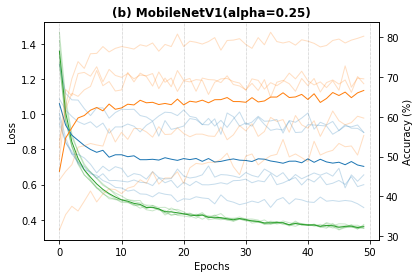

In [14]:
fig, ax = plt.subplots()
plot_single_lr_history(ax, history)

In [15]:
# Plot history for single model
a="""
fig = mpl.figure.Figure((15, 10))
axes = fig.subplots(3, 3)
axes = axes.flatten()

fm = FineModel.get_dict()['mobilenet_a25']()
verbose_model_name = 'MobileNet(a=25)'
history = get_history_by_lr(fm, 2)


plot_single_lr_history(axes[0], history)
fig.tight_layout()

h0, l0 = ax.get_shared_x_axes().get_siblings(ax)[0].get_legend_handles_labels()
h1, l1 = ax.get_shared_x_axes().get_siblings(ax)[1].get_legend_handles_labels()
handles, labels = h0 + h1, l0 + l1
fig.legend(handles, labels, loc='upper center', ncol=len(labels))
"""

In [16]:
# Output history for one learning rate for 9 models
lr_index = 2

fig = mpl.figure.Figure((12, 10))
axes = fig.subplots(3, 3)
axes = axes.flatten()

for i, key in enumerate(MODEL_LABELS.keys()):
    fm = FineModel.get_dict()[key]()
    history = get_history_by_lr(fm, lr_index)
    left = (i % 3 == 0)
    right = (i % 3 == 2)
    plot_single_lr_history(axes[i], history, left_ylabel=left, right_ylabel=right)
fig.tight_layout()

# Add legend based on first ax
siblings = axes[0].get_shared_x_axes().get_siblings(ax) 
h0, l0 = siblings[0].get_legend_handles_labels()
h1, l1 = siblings[1].get_legend_handles_labels()
handles, labels = h0 + h1, l0 + l1
fig.legend(handles, labels, loc='lower center', ncol=len(labels))

fig.subplots_adjust(left=0, bottom=0.1, right=1, top=1, wspace=0.2, hspace=0.3)

fig.savefig('Learning Rate {} Variable Scale.png'.format(lr_index), dpi=320, bbox_inches="tight")
fig

TypeError: 'NoneType' object is not subscriptable